# 03 Seasonal Mosaics with the Open Data Cube part 2

This notebook follows on from 02 seasonal mosaics

The code in the cells below is direct copy from the 02 Seasonal Mosaics notebook. It is pasted here without further comment. Please refer back to that notebook

In [1]:
import datacube
import geopandas as gpd
import sys
sys.path.append('./utils')
import jncc_utils
import numpy as np
import pandas as pd
import rasterio
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
gdf = gpd.read_file('./data/SDNP.shp')

dc = datacube.Datacube()

query = {
    'time': ('2019-06-01','2019-08-31'),
    'output_crs': 'epsg:27700',
    'x': (gdf.total_bounds[0], gdf.total_bounds[2]),
    'y': (gdf.total_bounds[1], gdf.total_bounds[3]),
    'crs': 'epsg:27700',
    'resolution': (-10,10),
    'measurements':('red','green','blue','fmask', 'vmask')
}

ds = dc.load(product='sentinel2',
            dask_chunks = {},
            **query)
ds

<xarray.Dataset>
Dimensions:      (time: 48, y: 4940, x: 11371)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-01T11:06:21 ... 2019-08-30T11:...
  * y            (y) float64 1.444e+05 1.444e+05 ... 9.506e+04 9.504e+04
  * x            (x) float64 4.466e+05 4.467e+05 ... 5.603e+05 5.603e+05
    spatial_ref  int32 27700
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    fmask        (time, y, x) uint8 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    vmask        (time, y, x) uint8 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
Attributes:
    crs:           EPSG:27700
    grid_mapping:  spatial_ref

In [3]:
times = list(ds.time.values)
percentage_list=[]
for count, value in enumerate(times):
    data = ds.fmask.isel(time=count).values
    data2 = xr.where(data == 2, 1, data)
    data3 = data2.mean()
    percentage_list.append(data3)

data = {"times": times,
            "clean_percentage": percentage_list}

df = pd.DataFrame(data=data, columns=["times", "clean_percentage"])

In [5]:
timeslices = list(df.index[df.clean_percentage < 0.4])

ds2 = ds.isel(time=timeslices)
valid = ds2.where(ds2.vmask == 1)
masked = ds2.where(ds2.fmask == 0)
cleaned_dataset = ds2.where(valid)

The last cell above sets some parameters for input into the create_median_mosaic function and rgb function and export slice to geotiff which has been adapted from https://github.com/ceos-seo/data_cube_utilities released under a apache 2.0 license https://github.com/ceos-seo/data_cube_utilities/blob/master/LICENSE

In [6]:
median_composite = jncc_utils.create_median_mosaic(masked, cleaned_dataset, nodata = 0)

create_median_mosaic was written for Landsat data but can be adapted for Sentinel 2

/home/jovyan/mambaforge/envs/datacube/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


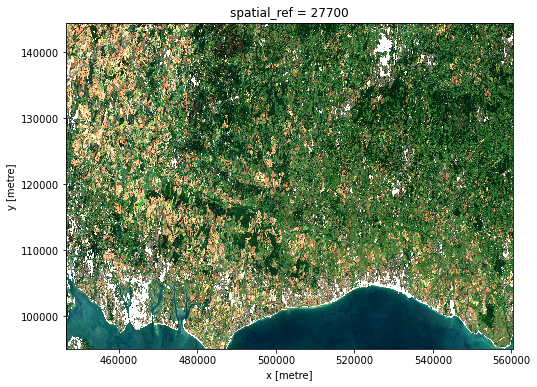

In [7]:
jncc_utils.rgb(median_composite, bands=["red", "green", "blue"], robust=True)

## It is very important to understand a) The UK is a cloudy place, and b) the ARD cloud masks are poor quality. 
We therefore do get cloudy mosaics. Adjust the threshold for clouds and extend the date range for best results

Export the data - will reside on the Jupyter Instance so you will need to download

In [ ]:
jncc_utils.export_slice_to_geotiff(median_composite, 'median_composite_summer_2019.tif')